# Comparison of East River ASO and Nearby SNTL
--------------------------------
### Daniel Hogan
### University of Washington 
- SNOTEL data taken from NRCS using the sript get_east_river_sntl_data.py
- ASO data downloaded for 2016, 2018, 2019, and 2022 from NSIDC

In [53]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from metloom.pointdata import SnotelPointData

import datetime as dt

import rioxarray as rioxr
import geopandas as gpd
import fiona 
fiona.drvsupport.supported_drivers['KML'] = 'rw'
import contextily as cx

import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import plot, mask

### All included setup code
- ER Polygon

In [2]:
# Polygon for Upper East River
upper_east_river_poly = gpd.read_file('./multisite/polygons/east_polygon.json')
upper_east_river_area = upper_east_river_poly.area # m^2

### Pull in the SNOTEL data and Locations, then plot them on a map

In [44]:
er_sntl_data = xr.open_dataset('../../../../../storage/dlhogan/sos/data/east_river_sntl_20220930.nc')

In [5]:
snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("680:CO:SNTL", "Park Cone")
park_cone_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("737:CO:SNTL", "Schofield Pass")
schofield_pass_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0]

snotel_point = SnotelPointData("1141:CO:SNTL", "Upper Taylor")
upper_taylor_loc = snotel_point.get_daily_data(
    dt.datetime(2020, 1, 2), dt.datetime(2020, 1, 2),
    [snotel_point.ALLOWED_VARIABLES.SWE]
).geometry.iloc[0].to_crs


### Start building basemap

In [22]:
sntl_gdf = gpd.GeoSeries([butte_loc,park_cone_loc,schofield_pass_loc,upper_taylor_loc]).set_crs('4326')
sntl_gdf_local = sntl_gdf.to_crs(upper_east_river_poly.crs)

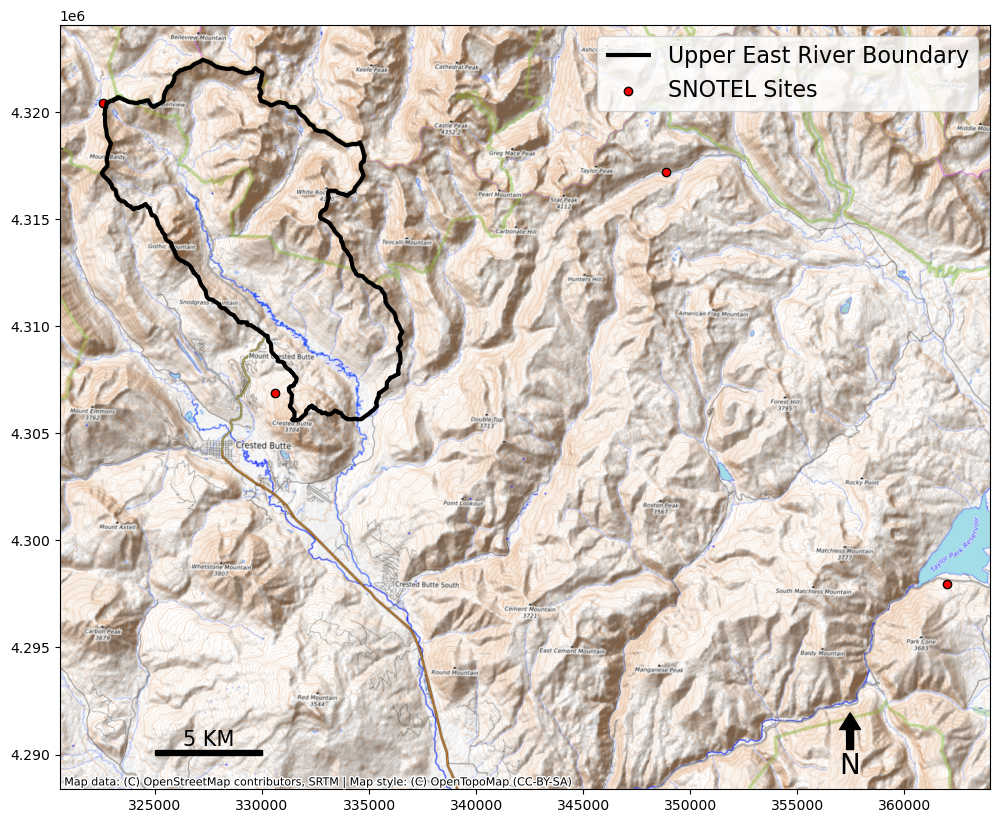

In [42]:
#Now making a basemap in contextily

ax = upper_east_river_poly.boundary.plot(color='k', linewidth=3, label='Upper East River Boundary', figsize=(12,12),edgecolor='k')

#Add north arrow, https://stackoverflow.com/a/58110049/604456
x, y, arrow_length = 0.85, 0.10, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# #Add scale-bar
x, y, scale_len = 325000, 4.295e6, 5000 #arrowstyle='-'
scale_rect = patches.Rectangle((x,y),scale_len,200,linewidth=1,edgecolor='k',facecolor='k')
ax.add_patch(scale_rect)
plt.text(x+scale_len/2, y+400, s='5 KM', fontsize=15, horizontalalignment='center')

#Add in hospitals as points
sntl_gdf_local.plot(c="r", alpha=1, ec='k', label='SNOTEL Sites', ax=ax)

#Now making a nice legend
ax.legend(loc='upper right', prop={'size': 16})

#Now adding in the basemap imagery
cx.add_basemap(ax, crs=upper_east_river_poly.crs.to_string(), source=cx.providers.OpenTopoMap)


### Get ASO files, load up and compute basin mean value

In [54]:
ASO_swe_files = glob.glob('/storage/dlhogan/sos/data/ASO/ASO_50M_SWE.001/*.tif')

In [55]:
ASO_swe_files

['/storage/dlhogan/sos/data/ASO/ASO_50M_SWE.001/ASO_50M_SWE_USCOCB_20160404.tif',
 '/storage/dlhogan/sos/data/ASO/ASO_50M_SWE.001/ASO_50M_SWE_USCOCB_20180330.tif',
 '/storage/dlhogan/sos/data/ASO/ASO_50M_SWE.001/ASO_50M_SWE_USCOGE_20180331.tif',
 '/storage/dlhogan/sos/data/ASO/ASO_50M_SWE.001/ASO_50M_SWE_USCOGE_20180524.tif',
 '/storage/dlhogan/sos/data/ASO/ASO_50M_SWE.001/ASO_50M_SWE_USCOGE_20190407.tif',
 '/storage/dlhogan/sos/data/ASO/ASO_50M_SWE.001/ASO_50M_SWE_USCOGE_20190610.tif',
 '/storage/dlhogan/sos/data/ASO/ASO_50M_SWE.001/ASO_Gunnison_EastRiver_2022Apr21_swe_50m.tif']

In [60]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
dates = [dt.date(2016,4,4), dt.date(2018,3,30),dt.date(2018,3,31),dt.date(2018,5,24),dt.date(2019,4,7),dt.date(2019,6,10),dt.date(2022,4,21)]

# create empty dictionaries to fill
aso_swe_mean_dict = {}
aso_swe_std_dict = {}
aso_swe_date_dict = dict(zip(ASO_swe_files, dates))

for i,file in enumerate(ASO_swe_files):
    src_swe = rasterio.open(file)
    src_ma_swe, src_ma_transform = rasterio.mask.mask(src_swe, upper_east_river_poly.geometry,**rio_mask_kwargs)
    east_ma_extent = rasterio.plot.plotting_extent(src_ma_swe, src_ma_transform)
    # Save mean and standard deviation in centimeters
    aso_swe_mean_dict[file[:-4]] = src_ma_swe.mean()*100
    aso_swe_std_dict[file[:-4]] = src_ma_swe.std()*100


In [71]:
pd.DataFrame([aso_swe_date_dict.values(),aso_swe_mean_dict.values(),aso_swe_std_dict.values()]).T

TypeError: __init__() got an unexpected keyword argument 'axis'

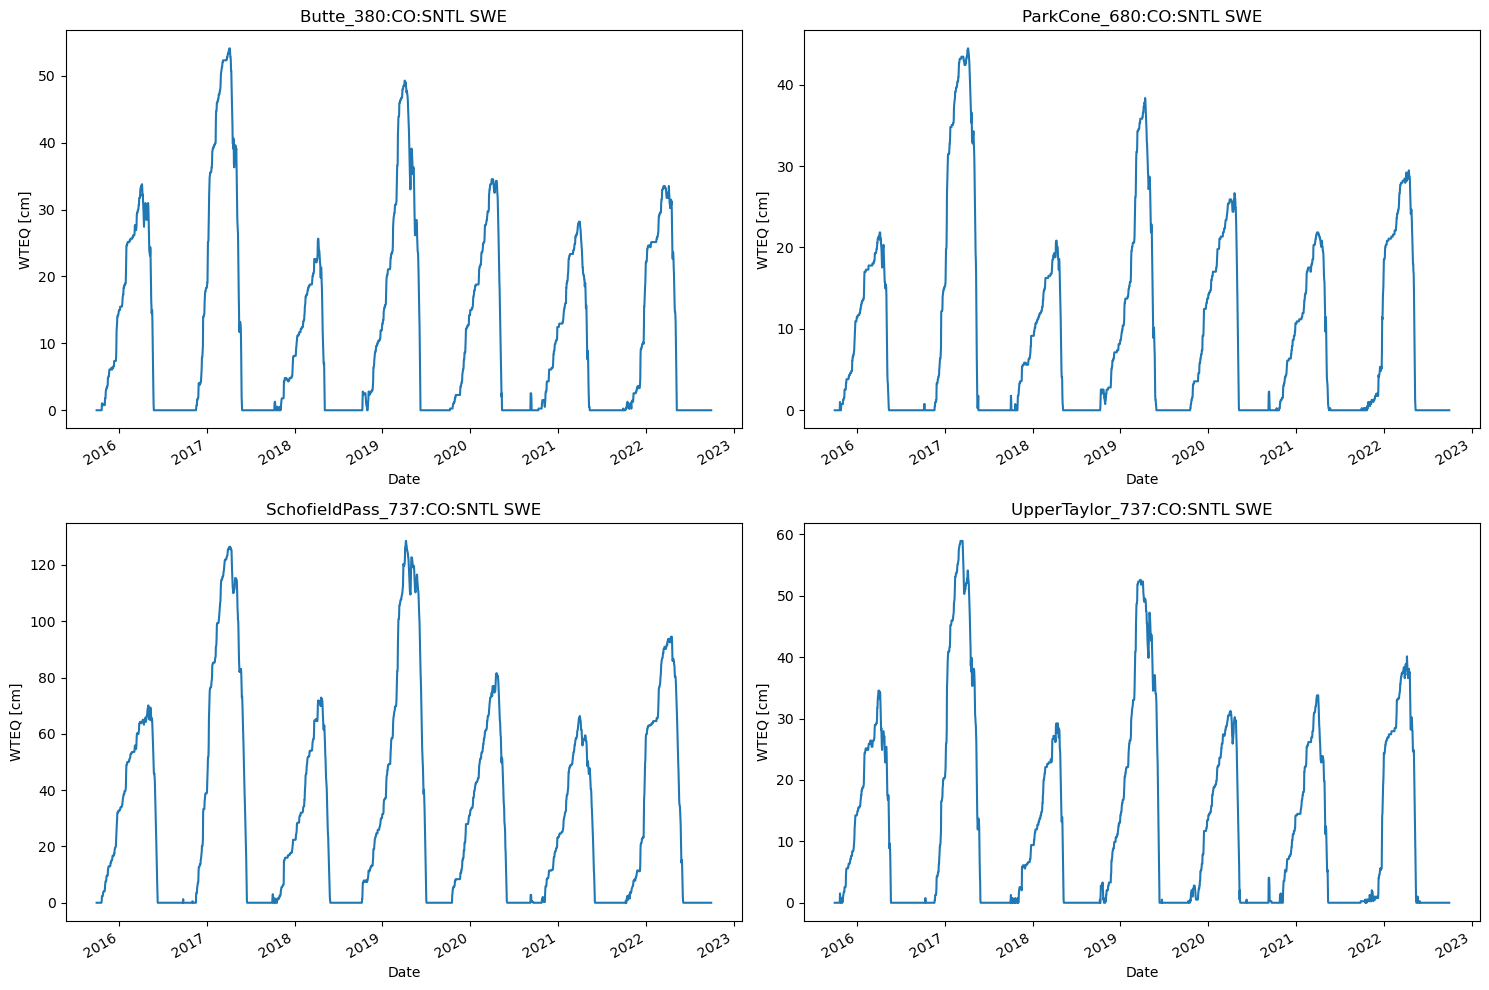

In [ ]:
# Create a plot for a time series of each SNOTEL site from 2016 to 2022
er_sntl_2016_2022 = er_sntl_data.sel(Date=slice('2015-10-01','2022-09-30'))

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,10), tight_layout=True)
axs=axs.ravel()
for i,loc in enumerate(er_sntl_2016_2022.Location):
    ax = axs[i]
    er_sntl_2016_2022.sel(Location=loc).WTEQ.plot(ax=ax)
    aso_stats_df['mean'].plot.errorbar(aso_stats_df['std'], label='ASO SWE')
    ax.set_title(f'{loc.values} SWE')
    ax.set_ylim(0,130)


# Visualize SWE if desired

In [ ]:
fig, ax = plt.subplots(figsize=(10,20))

# east_river_polygon.boundary.plot(ax=ax,label='East River Watershed', color='r', ls='--')
cax = ax.imshow(src_ma_swe, extent=east_ma_extent, cmap='Blues', vmin=0, vmax=0.5)
ax.set_title(f'March 31, 2018 SWE - Mean = {src_ma_swe.mean()} m')
plt.colorbar(cax, label = 'SWE (m)', ax=ax, fraction=0.046, pad=0.04)